In [1]:
try:
    import geopandas as gpd
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r $ICESAT2_BOREAL_REPO_PATH/dps/requirements_main.txt
    
import geopandas as gpd
import pandas as pd
import os
import json
import collections
import numpy as np
import sys
import s3fs
import matplotlib.pyplot as plt
import rasterio as rio
print("Importing packages complete.")
from shapely.geometry import Polygon
from shapely.geometry import box

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Importing packages complete.


In [2]:
def local_to_s3(url, user = 'nathanmthomas', type='public'):
    ''' A Function to convert local paths to s3 urls'''
    if type == 'public':
        replacement_str = f's3://maap-ops-workspace/shared/{user}'
    else:
        replacement_str = f's3://maap-ops-workspace/{user}'
    return url.replace(f'/projects/my-{type}-bucket', replacement_str)

In [9]:
import glob, os
import pandas as pd

fn_sar_list = glob.glob('/projects/my-public-bucket/sentinel1_seasonal_comps/S1_RTC_tindex/Fall/*.tif')

# set up lists for attributes
filepaths = []
geom = []
tile_nums=[]
for file in fn_sar_list:
    with rio.open(file) as f:
        # get image bounds and transform to 4326
        xmin, ymin, xmax, ymax = f.bounds
        #shapely box: minx, miny, maxx, maxy of S1 bounds
        poly = box(xmin,ymin,xmax,ymax)
        geom.append(poly)
        filepaths.append(file)
        tile_nums.append(file.split('/')[-1].split('_')[2])
        in_crs = f.crs
        
gdf = gpd.GeoDataFrame({'filepath':filepaths, 'tile_num':tile_nums, 'geometry':geom}, crs=in_crs)

gdf


,filepath,tile_num,geometry
0,/projects/my-public-bucket/sentinel1_seasonal_...,10,"POLYGON ((-2151478.000 9153304.000, -2151478.0..."
1,/projects/my-public-bucket/sentinel1_seasonal_...,111,"POLYGON ((-1971478.000 8433304.000, -1971478.0..."
2,/projects/my-public-bucket/sentinel1_seasonal_...,112,"POLYGON ((-1881478.000 8433304.000, -1881478.0..."
3,/projects/my-public-bucket/sentinel1_seasonal_...,113,"POLYGON ((-1791478.000 8433304.000, -1791478.0..."
4,/projects/my-public-bucket/sentinel1_seasonal_...,114,"POLYGON ((-1701478.000 8433304.000, -1701478.0..."
...,...,...,...
88,/projects/my-public-bucket/sentinel1_seasonal_...,6,"POLYGON ((-1971478.000 9243304.000, -1971478.0..."
89,/projects/my-public-bucket/sentinel1_seasonal_...,72,"POLYGON ((-2241478.000 8613304.000, -2241478.0..."
90,/projects/my-public-bucket/sentinel1_seasonal_...,73,"POLYGON ((-2151478.000 8613304.000, -2151478.0..."
91,/projects/my-public-bucket/sentinel1_seasonal_...,94,"POLYGON ((-1791478.000 8523304.000, -1791478.0..."


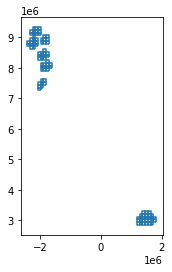

In [10]:
if True:
    out_foot_fn = '/projects/my-public-bucket/sentinel1_seasonal_comps/S1_RTC_tindex/footprints_sentinel1_Fall.gpkg'
    gdf.boundary.plot()
    
    gdf['s3_path'] = [local_to_s3(f, user='nathanmthomas') for f in gdf['filepath'].tolist()]
    gdf.to_file(out_foot_fn, driver='GPKG')
    gdf.head()

### Build Mosaic Json

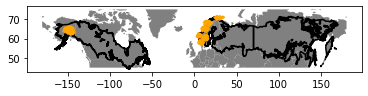

In [39]:
import shapely
# Corrections were made to ensure GeoJSON *_tindex_master.json was set correctly to 4326
gdf_4326 = gdf.to_crs("EPSG:4326")

#Write copy to disk for debug 
out_mosaic_json_fn = '/projects/my-public-bucket/sentinel1_seasonal_comps/S1_RTC_tindex/footprints_sentinel1_Fall.json'
gdf_4326.to_file(out_mosaic_json_fn, driver='GeoJSON')

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )

# Create a custom polygon
polygon = shapely.geometry.Polygon([(-180, 45), (-180, 75), (180, 75), (180, 45), (-180, 45)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
#poly_gdf.plot()
world_clip = gpd.clip(world, poly_gdf)
ax = world_clip.plot(color='gray')

boreal = gpd.read_file('/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
ax = boreal.boundary.plot(color='black', ax=ax)
gdf_4326.boundary.plot(color='orange', ax=ax)

out_mosaic_json = gdf_4326.to_json()

# This is formatted nicely (printed)
mosaic_geojson = json.loads(out_mosaic_json)



In [42]:
from typing import Dict
from cogeo_mosaic.mosaic import MosaicJSON
from cogeo_mosaic.backends import MosaicBackend

def get_accessor(feature: Dict):
    """Return specific feature identifier."""
    return feature["properties"]["s3_path"]

out_mosaic_json = '/projects/my-public-bucket/sentinel1_seasonal_comps/S1_RTC_tindex/footprints_sentinel1_Fall_mosaicjson.json'

print(f"Building {out_mosaic_json}")
mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

with MosaicBackend(out_mosaic_json, mosaic_def=mosaicdata) as mosaic:
    mosaic.write(overwrite=True)

Building /projects/my-public-bucket/sentinel1_seasonal_comps/S1_RTC_tindex/footprints_sentinel1_Fall_mosaicjson.json
